In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_condition = "Pancreas SS2"

# Loading 5 Pancreas datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## visualization  of the original data

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


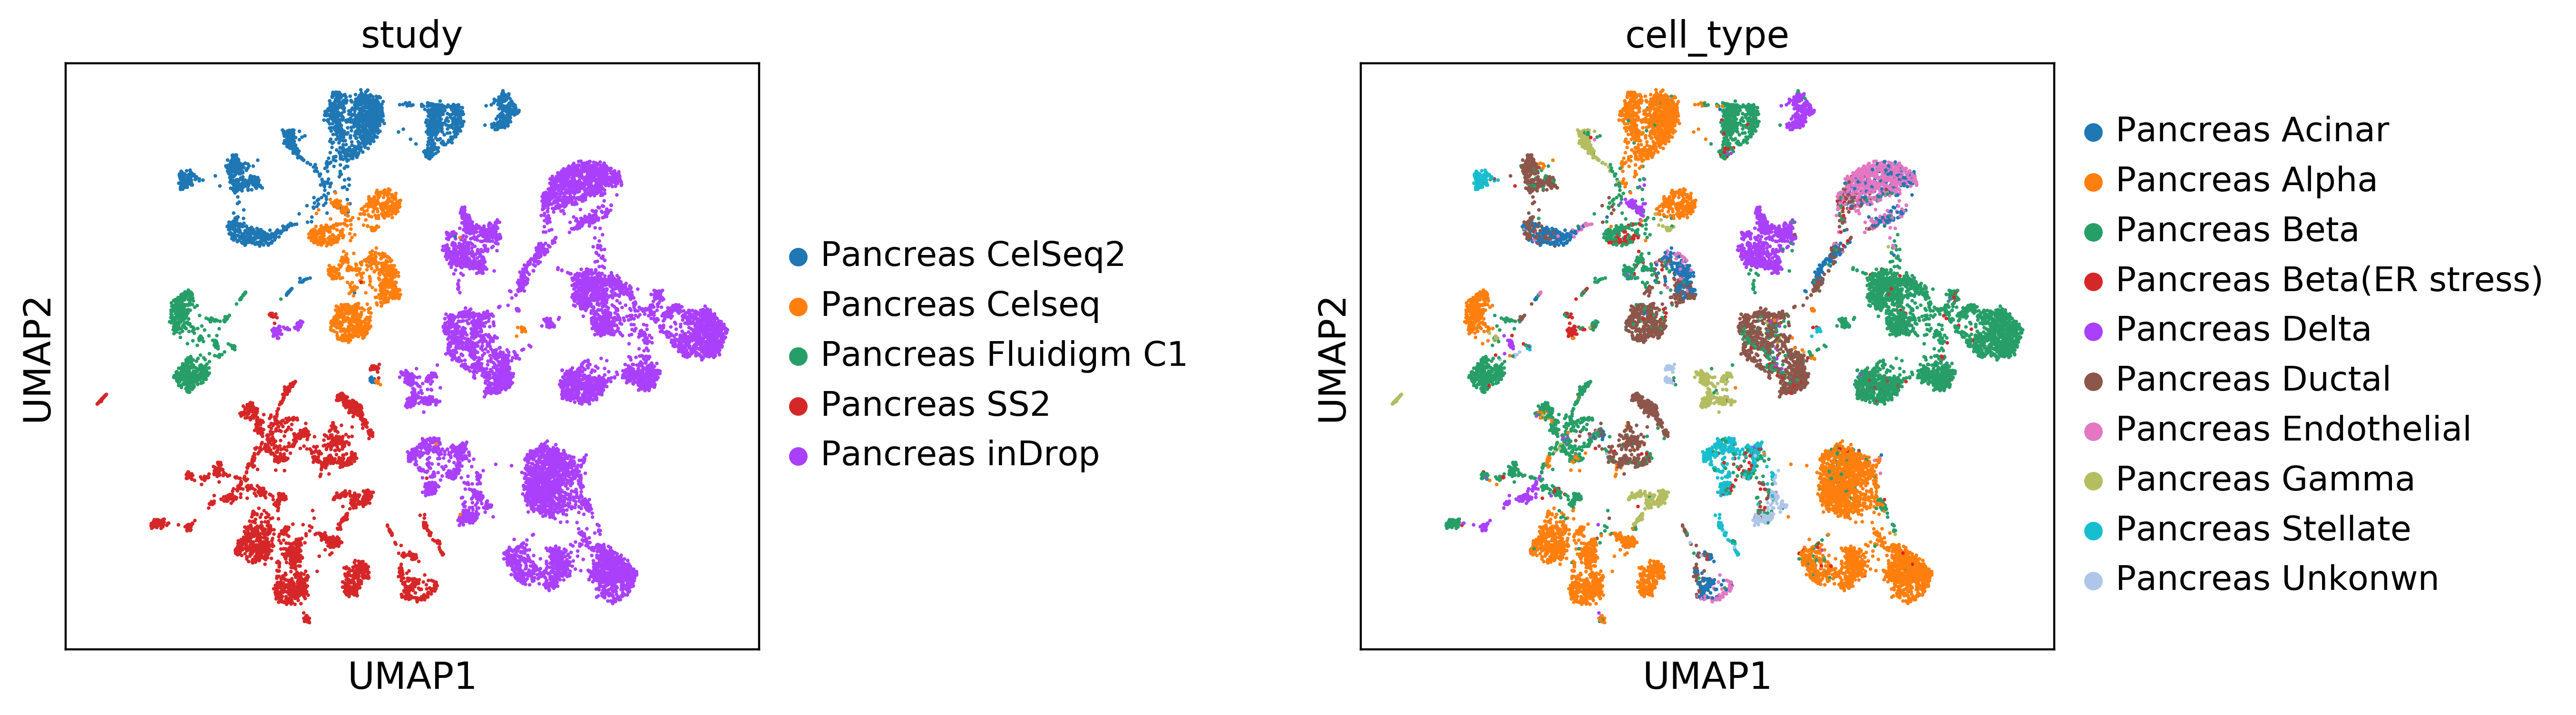

In [12]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 12932 × 15369 
    obs: 'batch', 'study', 'cell_type'

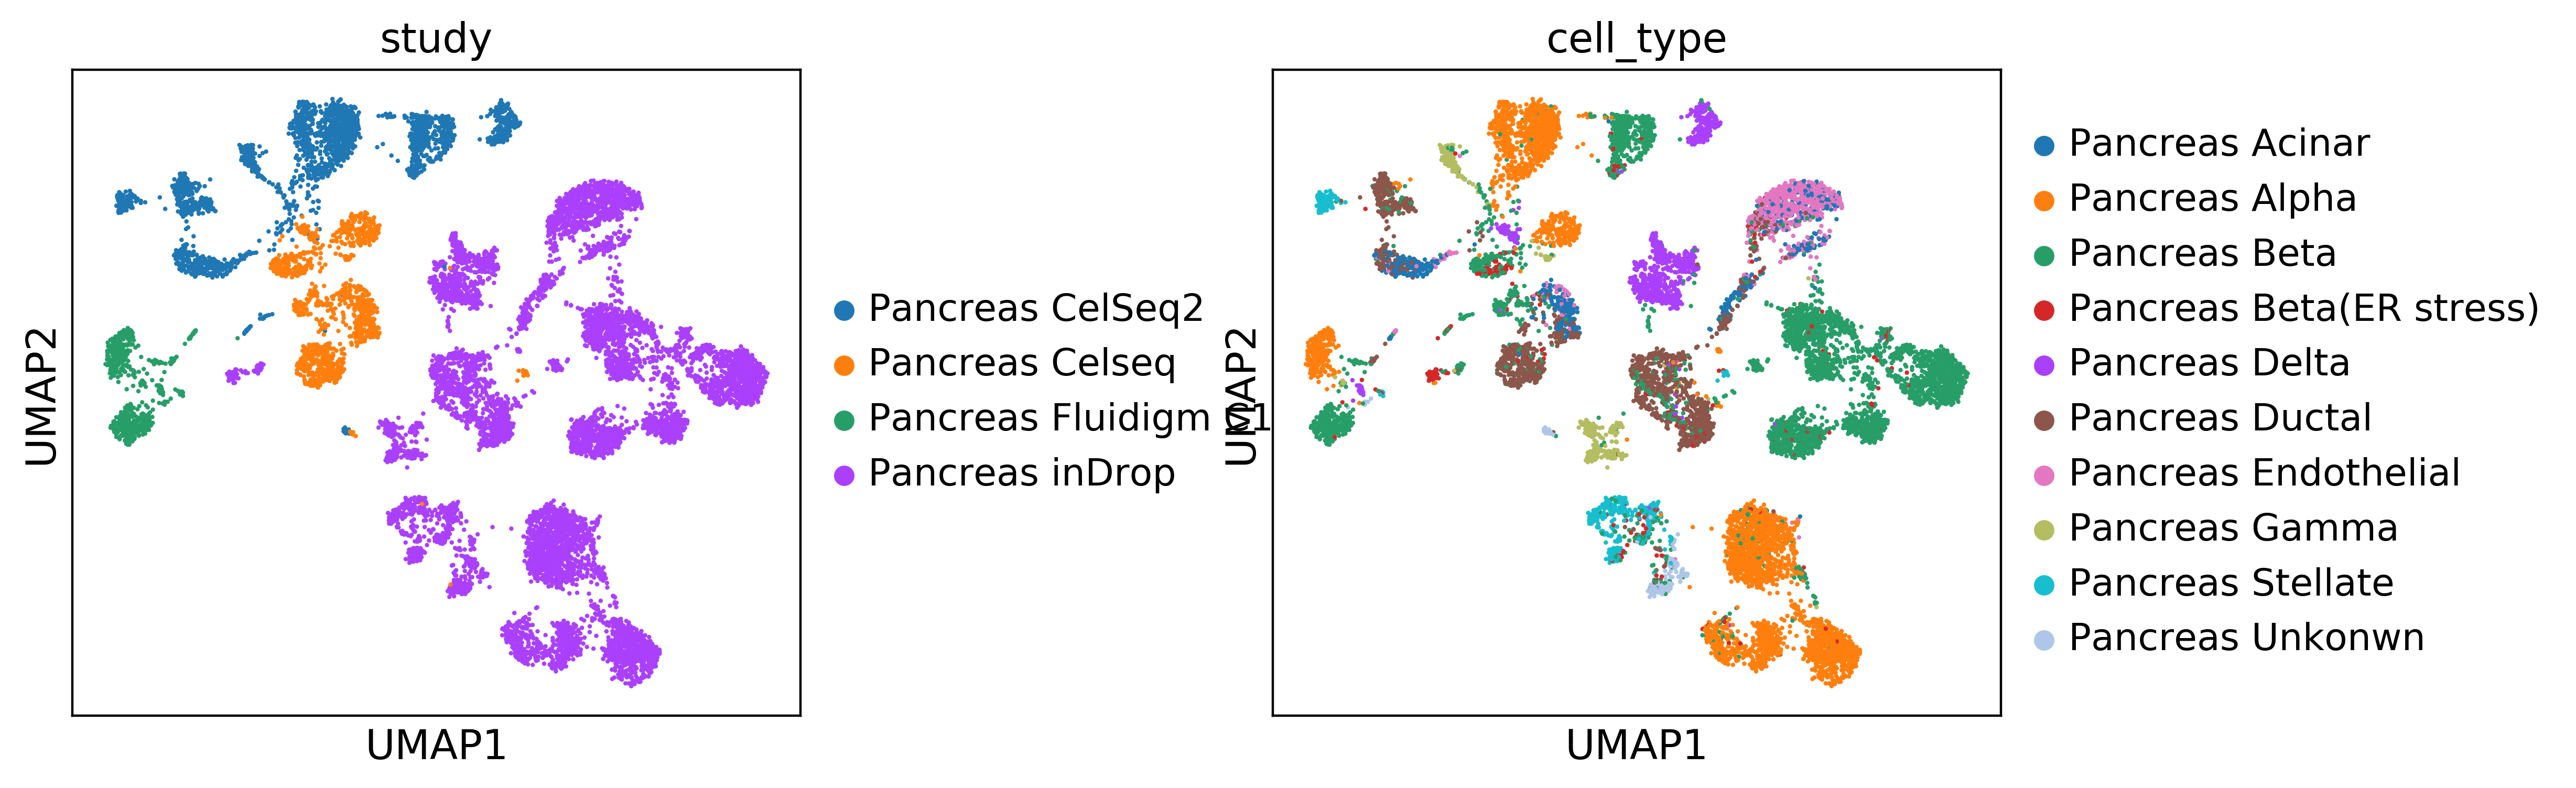

In [14]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 2989 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Normalization

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((10992, 2000), (1940, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026048     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [14]:
conditions = adata.obs[condition_key].unique().tolist()
target_conditions = [target_condition]
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq2': 1,
 'Pancreas Celseq': 2,
 'Pancreas Fluidigm C1': 3}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 10992 samples, validate on 1940 samples
Epoch 1/200
 - 2s - loss: 0.5240 - nb: 0.5240 - val_loss: 0.4366 - val_nb: 0.4366
Epoch 2/200
 - 1s - loss: 0.4224 - nb: 0.4224 - val_loss: 0.4133 - val_nb: 0.4133
Epoch 3/200
 - 1s - loss: 0.4129 - nb: 0.4129 - val_loss: 0.4063 - val_nb: 0.4063
Epoch 4/200
 - 1s - loss: 0.4073 - nb: 0.4073 - val_loss: 0.4027 - val_nb: 0.4027
Epoch 5/200
 - 1s - loss: 0.4034 - nb: 0.4034 - val_loss: 0.3992 - val_nb: 0.3992
Epoch 6/200
 - 1s - loss: 0.4007 - nb: 0.4007 - val_loss: 0.3986 - val_nb: 0.3986
Epoch 7/200
 - 1s - loss: 0.3984 - nb: 0.3984 - val_loss: 0.3964 - val_nb: 0.3964
Epoch 8/200
 - 1s - loss: 0.3964 - nb: 0.3964 - val_loss: 0.3938 - val_nb: 0.3938
Epoch 9/200
 - 1s - loss: 0.3952 - nb: 0.3952 - val_loss: 0.3930 - val_nb: 0.3930
Epoch 10/200
 - 1s - loss: 0.3939 - nb: 0.3939 - val_loss: 0.3936 - val_nb: 0.3936
Epoch 11/200
 - 1s - loss: 0.3928 - nb: 0.3928 - val_loss: 0.3913 - val_nb: 0.3913

In [16]:
network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq2': 1,
 'Pancreas Celseq': 2,
 'Pancreas Fluidigm C1': 3}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 10992 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

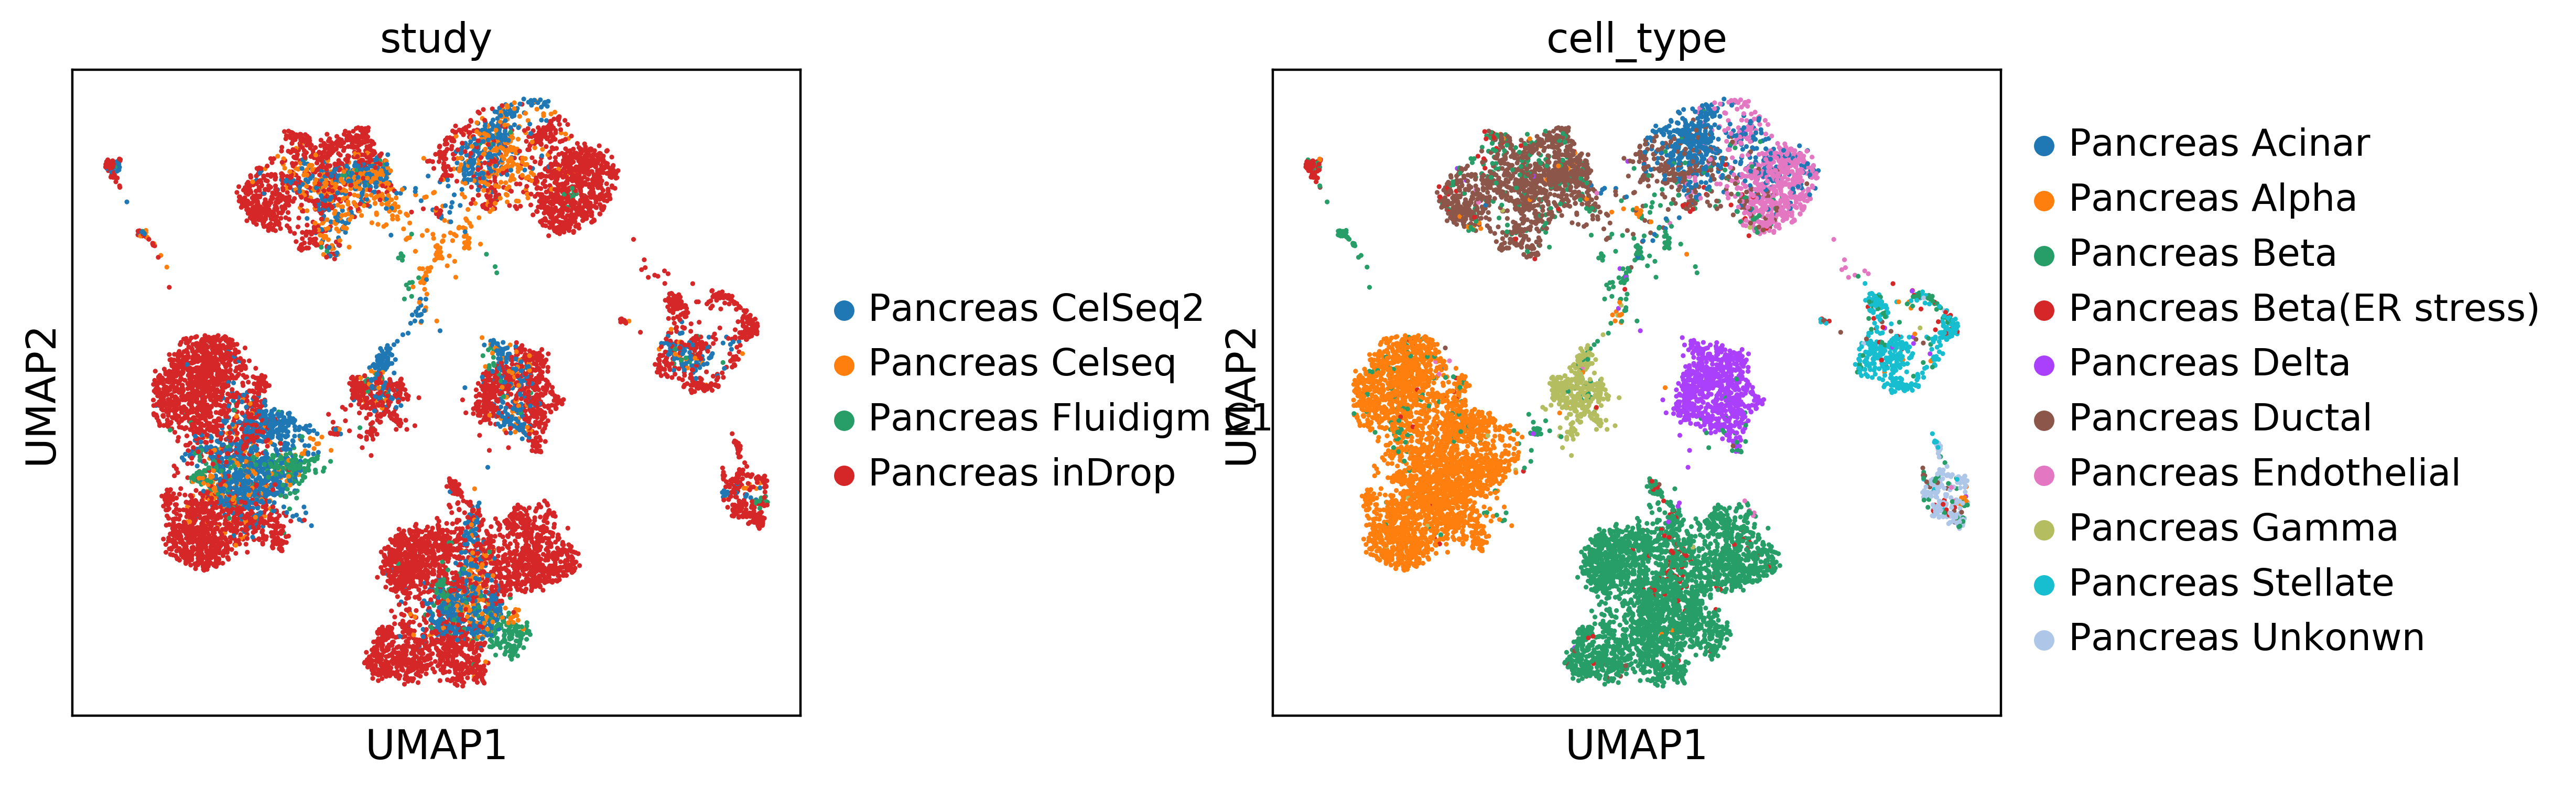

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [21]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026560     concatenate_3[0][0]              
__________

In [22]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq2': 1,
 'Pancreas Celseq': 2,
 'Pancreas Fluidigm C1': 3,
 'Pancreas SS2': 4}

## Train with small new dataset containing out-of-sample condition

In [23]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [24]:
train_adata.shape, valid_adata.shape

((2540, 2000), (449, 2000))

In [25]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 2540 samples, validate on 449 samples
Epoch 1/100
 - 1s - loss: 19.4737 - nb: 19.4737 - val_loss: 13.6136 - val_nb: 13.6136
Epoch 2/100
 - 0s - loss: 14.4714 - nb: 14.4714 - val_loss: 11.5396 - val_nb: 11.5396
Epoch 3/100
 - 0s - loss: 12.4898 - nb: 12.4898 - val_loss: 11.0505 - val_nb: 11.0505
Epoch 4/100
 - 0s - loss: 11.3189 - nb: 11.3189 - val_loss: 11.3518 - val_nb: 11.3518
Epoch 5/100
 - 0s - loss: 10.4787 - nb: 10.4787 - val_loss: 11.6178 - val_nb: 11.6178
Epoch 6/100
 - 0s - loss: 9.7908 - nb: 9.7908 - val_loss: 11.9416 - val_nb: 11.9416
Epoch 7/100
 - 0s - loss: 9.3551 - nb: 9.3551 - val_loss: 11.8573 - val_nb: 11.8573
Epoch 8/100
 - 0s - loss: 8.9822 - nb: 8.9822 - val_loss: 12.3381 - val_nb: 12.3381
Epoch 9/100
 - 0s - loss: 8.6687 - nb: 8.6687 - val_loss: 11.3723 - val_nb: 11.3723
Epoch 10/100
 - 0s - loss: 8.4351 - nb: 8.4351 - val_loss: 11.5396 - val_nb: 11.5396
Epoch 11/100
 - 0s - loss: 8.2560 - nb: 8.2560 - val_loss: 11.2758 - val_nb: 11.2758
Epoch 12/100
 - 0

In [29]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(15921, 1)

In [32]:
adata = surgeon.utils.normalize(adata, 
                                 filter_min_counts=False, 
                                 normalize_input=False, 
                                 size_factors=True,
                                 logtrans_input=True,
                                 n_top_genes=2000,
                                )

In [27]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

In [34]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 15921 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [35]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

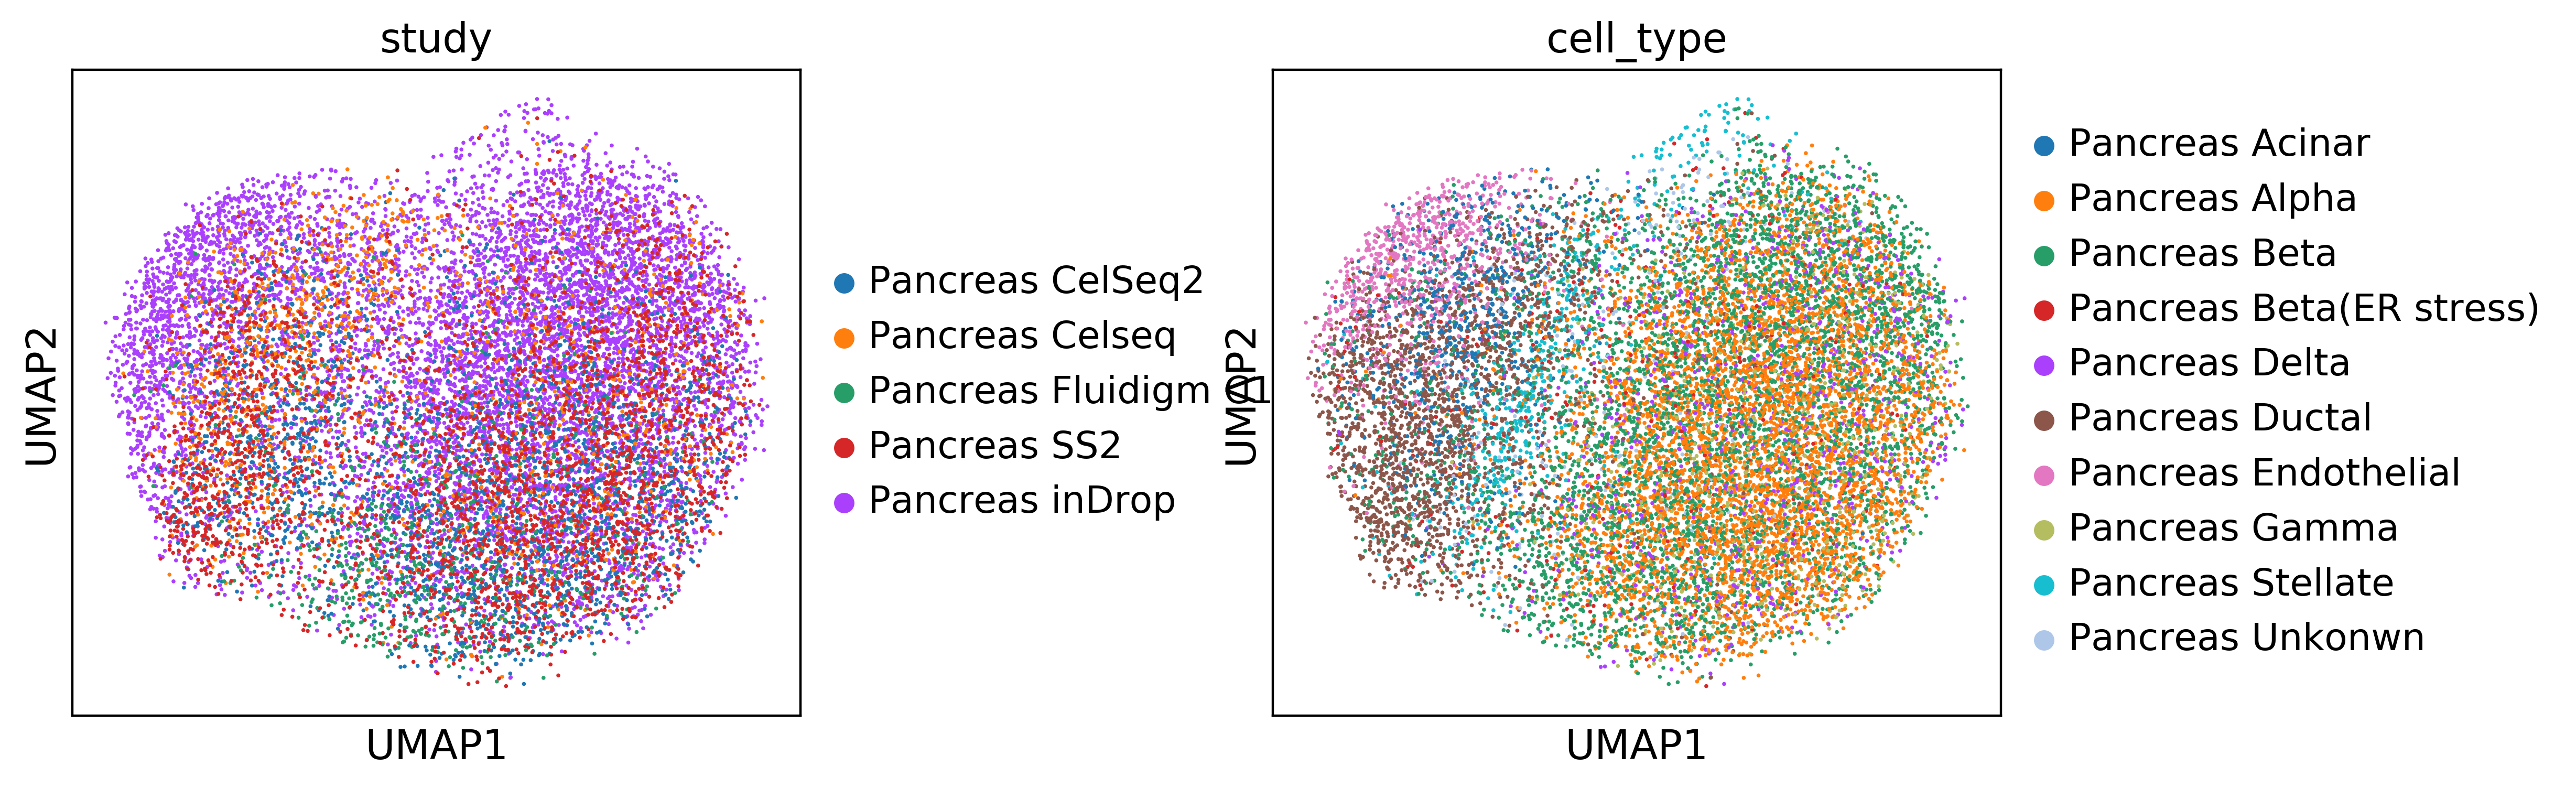

In [36]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)